In [93]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [94]:
import numpy as np
import pandas as pd

In [95]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [96]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [97]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [98]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [99]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [100]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [101]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

* Design a query to retrieve the last 12 months of precipitation data and plot the results

* Calculate the date 1 year ago from the last data point in the database

* Perform a query to retrieve the data and precipitation scores

* Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

### Get Data Using Raw SQL Query 

In [102]:
conn = engine.connect() ## Important statement to connect to the database. 
val = conn.execute("""select station, date, prcp
                      from measurement
                      where date between '2016-08-23' and '2017-08-23'
                       order by date;""");

results = val.fetchall()


### Get Data Using SQL Alchemy Query Types 

In [103]:
val2 = sqlalchemy.select([Station])
result2 = conn.execute(val2).fetchall()
key_vals = conn.execute(val2).keys()
key_vals

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [104]:
table_select = sqlalchemy.select([Measurement.station, Measurement.date, Measurement.prcp])
result = conn.execute(table_select).fetchall()
key_table = conn.execute(table_select).keys()
print(key_table)
result;


['station', 'date', 'prcp']


In [105]:
m = session.query(Measurement)
session.execute(m).keys()

['measurement_id',
 'measurement_station',
 'measurement_date',
 'measurement_prcp',
 'measurement_tobs']

In [106]:
table2 = session.query(Measurement.station, Measurement.date, Measurement.prcp).filter(Measurement.date >= '2016-08-23').all()
table2; # Final Result Needed

In [107]:
df = pd.DataFrame(table2)
df.columns = key_table # Only the column Names
df.set_index('date', inplace=True)
df

,station,prcp
date,,
2016-08-23,USC00519397,0.00
2016-08-24,USC00519397,0.08
2016-08-25,USC00519397,0.08
2016-08-26,USC00519397,0.00
2016-08-27,USC00519397,0.00
...,...,...
2017-08-19,USC00516128,0.09
2017-08-20,USC00516128,NaN
2017-08-21,USC00516128,0.56


In [108]:
# Use Pandas to calculate the summary statistics for the precipitation data

In [109]:
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [110]:
# Design a query to show how many stations are available in this dataset?
st_count = conn.execute("""select count(distinct station)
                      from measurement;""");
st_count.fetchall()

[(9,)]

In [111]:
st_count= session.query(func.count(sqlalchemy.distinct(Measurement.station))).all()
st_count

[(9)]

In [112]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station).label('Max_Count')).\
                  group_by(Measurement.station).order_by(sqlalchemy.desc(func.count(Measurement.station))).all()
active_stations;


In [113]:
df1 = pd.DataFrame(active_stations,columns=['Station ID','Number of Stations'])
df1

,Station ID,Number of Stations
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [114]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active = session.query(Measurement.station, func.min(Measurement.tobs), \
                            func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                  group_by(Measurement.station).\
                  order_by(sqlalchemy.desc(func.count(Measurement.station))).all()
most_active

[('USC00519281', 54.0, 85.0, 71.66378066378067),
 ('USC00519397', 56.0, 87.0, 74.55323054331865),
 ('USC00513117', 59.0, 85.0, 72.68918420081211),
 ('USC00519523', 56.0, 85.0, 74.5436493068565),
 ('USC00516128', 58.0, 84.0, 70.91500765696784),
 ('USC00514830', 58.0, 85.0, 74.8732970027248),
 ('USC00511918', 53.0, 87.0, 71.61596766043456),
 ('USC00517948', 58.0, 87.0, 74.68440233236151),
 ('USC00518838', 58.0, 83.0, 72.72407045009784)]

In [115]:
df2 = pd.DataFrame(most_active,columns=['Station ID','Min Temperature', 'Max Temperature', 'Average Temperature'])
df2

,Station ID,Min Temperature,Max Temperature,Average Temperature
0,USC00519281,54.0,85.0,71.663781
1,USC00519397,56.0,87.0,74.553231
2,USC00513117,59.0,85.0,72.689184
3,USC00519523,56.0,85.0,74.543649
4,USC00516128,58.0,84.0,70.915008
5,USC00514830,58.0,85.0,74.873297
6,USC00511918,53.0,87.0,71.615968
7,USC00517948,58.0,87.0,74.684402
8,USC00518838,58.0,83.0,72.724070


In [116]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the 
# results as a histogram
station_highest_obs = conn.execute(""" select tobs 
                                       from measurement
                                       where station = 
                                       (select station 
                                       from (SELECT station, max(count) 
                                             FROM (SELECT station,(count(tobs)) AS count
                                             FROM measurement
                                             GROUP BY station
                                             ORDER BY count(tobs) DESC)))
                                        ;
                                         """)

In [117]:
new_active = session.query(Measurement.station.label('Station'), func.count(Measurement.tobs).label('Count')).\
                           group_by(Measurement.station).\
                           order_by(sqlalchemy.desc(func.count(Measurement.tobs))).subquery()

In [118]:
max_active = session.query(new_active.c.Station.label('Station'), func.max(new_active.c.Count)).subquery()
max_active


<sqlalchemy.sql.selectable.Alias at 0x28153db1748; %(2754480904008 anon)s>

In [119]:
temp_max_station = session.query(Measurement.station, Measurement.tobs)\
                                 .filter(Measurement.station==max_active.c.Station).all()
df_temp = pd.DataFrame(temp_max_station, columns=['Station ID','Temperature'])
df_temp

,Station ID,Temperature
0,USC00519281,70.0
1,USC00519281,62.0
2,USC00519281,74.0
3,USC00519281,75.0
4,USC00519281,74.0
...,...,...
2767,USC00519281,77.0
2768,USC00519281,77.0
2769,USC00519281,76.0
2770,USC00519281,76.0


Text(0, 0.5, 'Frequency')

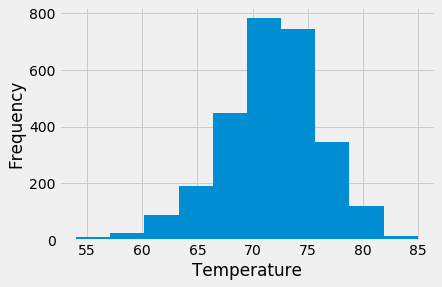

In [120]:
df_temp['Temperature'].hist()
plt.xlabel("Temperature")
plt.ylabel("Frequency")

In [121]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [122]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
dfavg = pd.DataFrame(calc_temps('2017-08-23', '2018-08-23'), columns=['Tmin','Tavg','Tmax'])
dfavg

,Tmin,Tavg,Tmax
0,76.0,80.25,82.0


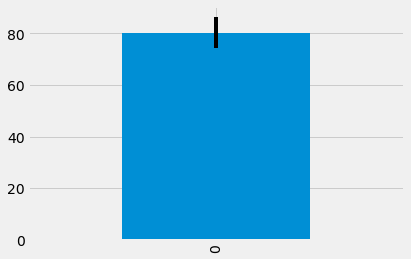

In [123]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = dfavg['Tmax'] - dfavg['Tmin']
dfavg['Tavg'].plot.bar(yerr=error)

In [124]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

tot_rainfall = session.query(Measurement.station.label('Station'), func.sum(Measurement.prcp).label('Total')).\
                             filter(Measurement.date >= '2016-08-23').\
                             filter(Measurement.date <= '2018-08-23').\
                             group_by(Measurement.station).\
                             order_by(sqlalchemy.desc(func.sum(Measurement.prcp))).subquery()

station_query = session.query(Station.station.label('Stat'), Station.name, Station.latitude, \
                              Station.longitude, Station.elevation).subquery()
final_table = session.query(tot_rainfall, station_query).\
                      filter(tot_rainfall.c.Station == station_query.c.Stat).\
                      order_by(sqlalchemy.desc(tot_rainfall.c.Total)).all()
df_table = pd.DataFrame(final_table, columns=['Station ID', 'Total Precipitation',  'Station ID', 
                                              'Station Name', 'Latitude', 'Longitude', 'Elevation'])
df_table

,Station ID,Total Precipitation,Station ID,Station Name,Latitude,Longitude,Elevation
0,USC00516128,147.81,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,70.03,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00513117,48.51,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00519523,38.01,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,USC00514830,33.24,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
5,USC00519397,16.09,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,USC00517948,4.59,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [125]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [126]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
start = dt.datetime.strptime("2018-04-25", "%Y-%m-%d")
end = dt.datetime.strptime("2018-06-21", "%Y-%m-%d")
date_generated = [start + dt.timedelta(days=x) for x in range(0, (end-start).days)]

date_list = list(map(lambda x: x.strftime("%m-%d"), date_generated))
print(date_list)

normals = [daily_normals(date)[0] for date in date_list]
normals

df_temps = pd.DataFrame(normals, columns=['Min_Temp','Avg_Temp', 'Max_Temp'])
df_temps['Dates'] = date_list 


['04-25', '04-26', '04-27', '04-28', '04-29', '04-30', '05-01', '05-02', '05-03', '05-04', '05-05', '05-06', '05-07', '05-08', '05-09', '05-10', '05-11', '05-12', '05-13', '05-14', '05-15', '05-16', '05-17', '05-18', '05-19', '05-20', '05-21', '05-22', '05-23', '05-24', '05-25', '05-26', '05-27', '05-28', '05-29', '05-30', '05-31', '06-01', '06-02', '06-03', '06-04', '06-05', '06-06', '06-07', '06-08', '06-09', '06-10', '06-11', '06-12', '06-13', '06-14', '06-15', '06-16', '06-17', '06-18', '06-19', '06-20']


In [127]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_temps.set_index('Dates', inplace=True)

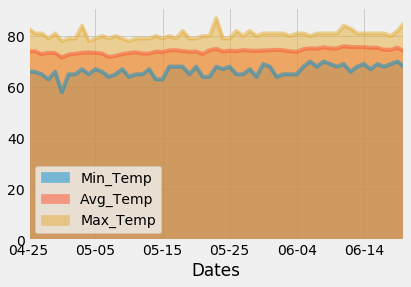

In [128]:
# Plot the daily normals as an area plot with `stacked=False`
df_temps.plot.area(stacked=False)